In [1]:
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
from CPT import CPT, read_file, pprint_tree

In [2]:
datafile = './data/train.csv'
%time data = read_file(datafile, id_col='ID', line_num_col='LINE_NB', code_col='CODE', require_sorting=False)

Wall time: 27.6 s


In [3]:
print("total nb of sequences %i" % len(data))

total nb of sequences 44358


In [4]:
data[:10]

[['UL', 'ULV'],
 ['PX9', 'L5TG', 'L5TG'],
 ['TP', 'TP', 'TP', 'TP', 'TP', 'TP', 'TP', 'TP', 'TP'],
 ['U4', '6ML'],
 ['PX9', 'RVX9L', 'L5TG', 'L5TG'],
 ['LYJ', 'LYJ', 'LYJ', 'PX9', 'LYJ', 'GL9L', 'L5TG', 'L5TG'],
 ['3PX', 'V5TG'],
 ['VPX', 'VPX'],
 ['PX9', 'RVX9L', 'L5TG', 'L5TG'],
 ['ZZ4', '4LV']]

In [5]:
# Split train and test

sample_size = 500

seq = pd.DataFrame({'seq':data})
test_sample = seq.sample(n=sample_size)
data_test = test_sample['seq'].to_list()
train = seq[~seq.index.isin(test_sample.index)]
data_train = train['seq'].to_list()

In [6]:
# Instantiate Model
my_cpt = CPT()

In [7]:
# Train Model
%time my_cpt.train(data, max_seq_length=10)
my_cpt.prune(2)

Wall time: 915 ms


In [8]:
# Predict

nb_of_preds = 3
%time result_with_score = my_cpt.predict(data_test, n=nb_of_preds, k=10, p=1, coef=2.5)

Wall time: 12.2 s


In [9]:
result = [[k for k,v in pred] for pred in result_with_score]
result_first = [x[0] for x in result]

ndf = pd.DataFrame(data={'Prefix':[l[:-1] for l in data_test],'Real':[l[-1:][0] for l in data_test],'Pred':result_first,'Full_Pred':result,'Full_Pred_Score':result_with_score})

In [10]:
ndf.head()

,Prefix,Real,Pred,Full_Pred,Full_Pred_Score
0,[86X],86X,86X,"[86X, 8QX, E6U]","[(86X, 0.73), (8QX, 0.16), (E6U, 0.11)]"
1,[ZZ4],4LV,VPX,"[VPX, ZZ4, 4LV]","[(VPX, 0.89), (ZZ4, 0.06), (4LV, 0.06)]"
2,[VPX],VPX,VPX,"[VPX, 86X, 9X9]","[(VPX, 0.99), (86X, 0.01), (9X9, 0.01)]"
3,"[UL, 9EV]",EJ5,3LV,"[3LV, 9EV, QLV]","[(3LV, 1.0), (9EV, 0.0), (QLV, 0.0)]"
4,"[UL, L9V]",ULV,VPX,"[VPX, E6X, L9V]","[(VPX, 1.0), (E6X, 0.0), (L9V, 0.0)]"


In [11]:
# % of predictions were the first result is the good one

accuracy = (ndf['Real']==ndf['Pred']).sum()/ndf.shape[0] * 100
print("%.2f %% of good predictions !" % accuracy)

44.60 % of good predictions !


In [12]:
# % of predictions were result is in the n first predictions

ok = []
for idx,row in ndf.iterrows():
#     print(row.Real in row.Full_Pred)
    if row.Real in row.Full_Pred:
        ok.append(idx)
        
accuracy = len(ok)/ndf.shape[0] * 100
print("%.2f %% in the %s first predictions" % (accuracy,nb_of_preds))

62.60 % in the 3 first predictions


In [13]:
# % of predictions with no result

no_answer = (ndf['Pred']=='--NO-RESULT--').sum()/ndf.shape[0] * 100
print("%.2f %%  without answer" % no_answer)

1.40 %  without answer


In [14]:
# example of good predictions

ndf[(ndf['Real']==ndf['Pred'])==True][:5]

,Prefix,Real,Pred,Full_Pred,Full_Pred_Score
0,[86X],86X,86X,"[86X, 8QX, E6U]","[(86X, 0.73), (8QX, 0.16), (E6U, 0.11)]"
2,[VPX],VPX,VPX,"[VPX, 86X, 9X9]","[(VPX, 0.99), (86X, 0.01), (9X9, 0.01)]"
5,[L9X],VPX,VPX,"[VPX, 3LV, E6X]","[(VPX, 0.98), (3LV, 0.01), (E6X, 0.01)]"
9,"[UVX, GMJ, UVX, GMJ, UVX, GMJ, UVX, GMJ, UVX]",GMJ,GMJ,"[GMJ, UVX, XJ8]","[(GMJ, nan), (UVX, nan), (XJ8, 0.0)]"
12,[VPX],VPX,VPX,"[VPX, 86X, 9X9]","[(VPX, 0.99), (86X, 0.01), (9X9, 0.01)]"


In [15]:
# example of bad predictions

ndf[(ndf['Real']==ndf['Pred'])==False][:5]

,Prefix,Real,Pred,Full_Pred,Full_Pred_Score
1,[ZZ4],4LV,VPX,"[VPX, ZZ4, 4LV]","[(VPX, 0.89), (ZZ4, 0.06), (4LV, 0.06)]"
3,"[UL, 9EV]",EJ5,3LV,"[3LV, 9EV, QLV]","[(3LV, 1.0), (9EV, 0.0), (QLV, 0.0)]"
4,"[UL, L9V]",ULV,VPX,"[VPX, E6X, L9V]","[(VPX, 1.0), (E6X, 0.0), (L9V, 0.0)]"
6,"[UL, L9V]",ULV,VPX,"[VPX, E6X, L9V]","[(VPX, 1.0), (E6X, 0.0), (L9V, 0.0)]"
7,[ZZ4],JFF4,4EV,"[4EV, 6ML]","[(4EV, 0.98), (6ML, 0.02)]"


In [16]:
def conf_matr_plot(ytest,ypred,threshold=0,normalize=True,show_diag=True,show_alls=False):
    conf_matr = pd.crosstab(ytest, ypred, rownames=['True'], colnames=['Predicted'], margins=True)
    
    # Filter rows < threshold * global_total
    n_threshold = threshold * conf_matr.loc['All','All']
    conf_matr = conf_matr.loc[(conf_matr['All']>n_threshold),:]  # keep rows > threshold
    
    # Normalize
    if normalize:
        conf_matr = conf_matr.div(conf_matr['All'],axis=0)  # Normalize matrix vs rowsum
#         conf_matr_norm = conf_matr_filter.div(conf_matr_filter.loc['All','All'],axis=0)  # Normalize matrix vs total
    
    # Remove diagonal elements (good predictions)
    if not show_diag:
        for idx, row in conf_matr.iterrows():  
            row.loc[row.name]=0
    
    # Remove columns <= threshold
    drop_col = []
    for col,seri in conf_matr.iteritems(): 
        if seri[seri.index!='All'].sum()<=threshold:
            drop_col.append(col)
    conf_matr = conf_matr.drop(columns=drop_col)
    
    # Drop totals
    if not show_alls:
        conf_matr = conf_matr.drop(columns='All')  # Drop column 'All' always = 1
        conf_matr = conf_matr[conf_matr.index != "All"]  # Drop Row 'All'
    
    conf_matr = round(conf_matr * 100,1)
    
    return conf_matr

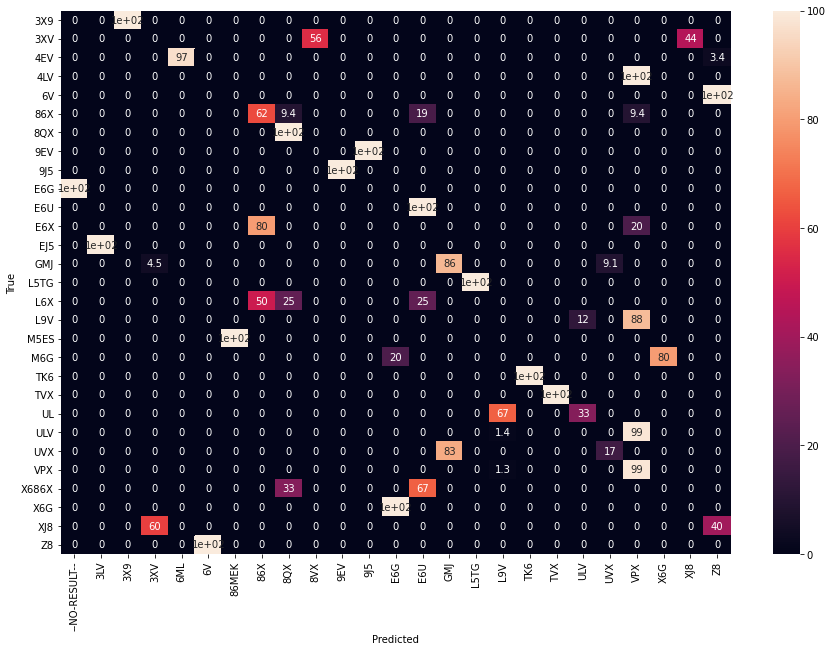

In [17]:
plt.rcParams['figure.figsize'] = [15, 10]
sns.heatmap(conf_matr_plot(ndf['Real'],ndf['Pred'],threshold=0.005,normalize=True,show_diag=True, show_alls=False),annot=True);

In [18]:
# Show Tree
pprint_tree(my_cpt.root_node)

TG = 2
   │  │  └─ V5TG = 2
   │  └─ L5TG = 2
   │     └─ L5TG = 2
   ├─ DWLJ9 = 8
   │  ├─ 8P69 = 2
   │  └─ $TL8 = 4
   ├─ EV9L = 4
   │  └─ EV9L = 2
   ├─ V£9 = 4
   │  └─ V£9 = 4
   │     └─ V£9 = 3
   │        └─ V£9 = 2
   ├─ BWLJ9 = 18
   │  ├─ 8P69 = 4
   │  ├─ $TL8 = 7
   │  ├─ $P69 = 2
   │  └─ BWLJ9 = 2
   │     └─ BWLJ9 = 2
   ├─ MWP69 = 6
   │  ├─ MWVJ9 = 2
   │  └─ MWP69 = 2
   ├─ M686X = 15
   │  ├─ MW9V8 = 9
   │  │  ├─ M6L6X = 2
   │  │  ├─ 5G = 2
   │  │  │  └─ L9V8 = 2
   │  │  └─ L9V8 = 2
   │  ├─ 5G = 2
   │  │  └─ MW9V8 = 2
   │  │     └─ 5G = 2
   │  └─ X6L6X = 2
   ├─ XV9L = 7
   │  ├─ XV9L = 2
   │  └─ R5TG = 5
   │     └─ R5TG = 2
   ├─ X4 = 3
   │  └─ 5G = 2
   ├─ L6X = 554
   │  ├─ 6UJ = 146
   │  │  └─ VPX = 6
   │  ├─ TL8 = 2
   │  ├─ L6X = 92
   │  │  ├─ L6X = 13
   │  │  ├─ 86X = 11
   │  │  ├─ 8QX = 2
   │  │  ├─ HXM = 3
   │  │  └─ 6UJ = 5
   │  ├─ E6U = 16
   │  │  └─ E6U = 3
   │  ├─ 9X9 = 22
   │  │  └─ L6X = 9
   │  │     └─ 6UJ = 2
   │  ├─ 86X = 